###### Reference : https://www.kaggle.com/code/victorambonati/unsupervised-anomaly-detection/notebook

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [3]:
# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

# # train markov model to get transition matrix
# def getTransitionMatrix (df):
#     df = np.array(df)
#     model = msm.estimate_markov_model(df, 1)
#     return model.transition_matrix

# def markovAnomaly(df, windows_size, threshold):
#     transition_matrix = getTransitionMatrix(df)
#     real_threshold = threshold**windows_size
#     df_anomaly = []
#     for j in range(0, len(df)):
#         if (j < windows_size):
#             df_anomaly.append(0)
#         else:
#             sequence = df[j-windows_size:j]
#             sequence = sequence.reset_index(drop=True)
#             df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
#     return df_anomaly

In [4]:
df = pd.read_csv('ambient_temperature_system_failure.csv')

In [5]:
df

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
...,...,...
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [7]:
# check the timestamp format and frequence 
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [8]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [10]:
# check the temperature mean
print(df['value'].mean())

71.2424327082882


In [11]:
print(df['value'].head(10))

0    69.880835
1    71.220227
2    70.877805
3    68.959400
4    69.283551
5    70.060966
6    69.279765
7    69.369608
8    69.166714
9    68.986083
Name: value, dtype: float64


In [12]:
# To convert temp in degrees Fahrenheit to Celsius, subtract 32 and multiply by . 5556 (or 5/9).
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9

In [13]:
print(df['value'].head(10))

0    21.044908
1    21.789015
2    21.598781
3    20.533000
4    20.713084
5    21.144981
6    20.710980
7    20.760894
8    20.648174
9    20.547824
Name: value, dtype: float64


<AxesSubplot:xlabel='timestamp'>

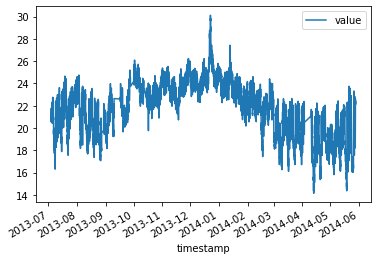

In [14]:
# plot the data
df.plot(x='timestamp', y='value')


# Feature engineering
Extracting some useful features

In [15]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour

In [16]:
df

,timestamp,value,hours
0,2013-07-04 00:00:00,21.044908,0
1,2013-07-04 01:00:00,21.789015,1
2,2013-07-04 02:00:00,21.598781,2
3,2013-07-04 03:00:00,20.533000,3
4,2013-07-04 04:00:00,20.713084,4
...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11
7263,2014-05-28 12:00:00,22.318309,12
7264,2014-05-28 13:00:00,22.248092,13
7265,2014-05-28 14:00:00,22.125126,14


In [17]:
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [18]:
df

,timestamp,value,hours,daylight
0,2013-07-04 00:00:00,21.044908,0,0
1,2013-07-04 01:00:00,21.789015,1,0
2,2013-07-04 02:00:00,21.598781,2,0
3,2013-07-04 03:00:00,20.533000,3,0
4,2013-07-04 04:00:00,20.713084,4,0
...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1
7263,2014-05-28 12:00:00,22.318309,12,1
7264,2014-05-28 13:00:00,22.248092,13,1
7265,2014-05-28 14:00:00,22.125126,14,1


In [19]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek


In [20]:
df

,timestamp,value,hours,daylight,DayOfTheWeek
0,2013-07-04 00:00:00,21.044908,0,0,3
1,2013-07-04 01:00:00,21.789015,1,0,3
2,2013-07-04 02:00:00,21.598781,2,0,3
3,2013-07-04 03:00:00,20.533000,3,0,3
4,2013-07-04 04:00:00,20.713084,4,0,3
...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2
7263,2014-05-28 12:00:00,22.318309,12,1,2
7264,2014-05-28 13:00:00,22.248092,13,1,2
7265,2014-05-28 14:00:00,22.125126,14,1,2


In [21]:
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)


In [22]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay
0,2013-07-04 00:00:00,21.044908,0,0,3,1
1,2013-07-04 01:00:00,21.789015,1,0,3,1
2,2013-07-04 02:00:00,21.598781,2,0,3,1
3,2013-07-04 03:00:00,20.533000,3,0,3,1
4,2013-07-04 04:00:00,20.713084,4,0,3,1
...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1
7263,2014-05-28 12:00:00,22.318309,12,1,2,1
7264,2014-05-28 13:00:00,22.248092,13,1,2,1
7265,2014-05-28 14:00:00,22.125126,14,1,2,1


In [23]:
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [24]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [25]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['WeekDay']*2 + df['daylight']

0       2
1       2
2       2
3       2
4       2
       ..
7262    3
7263    3
7264    3
7265    3
7266    3
Length: 7267, dtype: int32

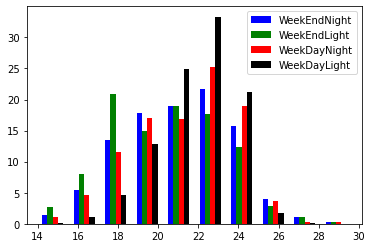

In [26]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

- We can see that the temperature is more stable during daylight of business day.

# Models
1 Cluster only

Use for collective anomalies (unordered).

We group together the usual combination of features. The points that are far from the cluster are points with usual combination of features.We consider those points as anomalies.

In [27]:
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [28]:
data

,0,1,2,3,4
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132
...,...,...,...,...,...
7262,0.265532,-0.073523,0.706815,-0.499330,0.62132
7263,0.219090,0.070841,0.706815,-0.499330,0.62132
7264,0.189332,0.215206,0.706815,-0.499330,0.62132
7265,0.137218,0.359571,0.706815,-0.499330,0.62132


In [29]:
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)

In [30]:
data

array([[ 0.08987032,  2.23882419],
       [-0.01278056,  2.10139375],
       [-0.01270697,  2.01220009],
       ...,
       [-0.92227757, -0.46789802],
       [-0.92959969, -0.56056451],
       [-0.99679206, -0.68134455]])

In [31]:
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

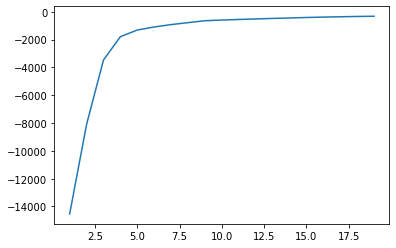

In [32]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [42]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[4].predict(data) #5
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

4    1878
1    1843
0    1522
2    1428
3     596
Name: cluster, dtype: int64

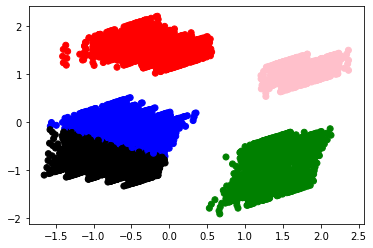

In [43]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [44]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[4])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result  (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

<ipython-input-3-5ddc76a93745>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series()


In [36]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,cluster,principal_feature1,principal_feature2,anomaly21
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2,8,0.066191,1.755363,0
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2,8,-0.009413,1.647609,0
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2,8,-0.009359,1.577677,0
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2,8,0.061592,1.543184,0
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2,8,0.031660,1.458262,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748,3,11,-0.663130,-0.218870,0
7263,2014-05-28 12:00:00,22.318309,12,1,2,1,14012784,3,7,-0.669607,-0.292067,0
7264,2014-05-28 13:00:00,22.248092,13,1,2,1,14012820,3,7,-0.679271,-0.366858,0
7265,2014-05-28 14:00:00,22.125126,14,1,2,1,14012856,3,7,-0.684664,-0.439514,0


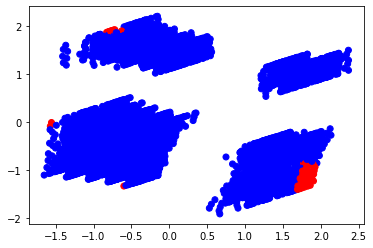

In [37]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

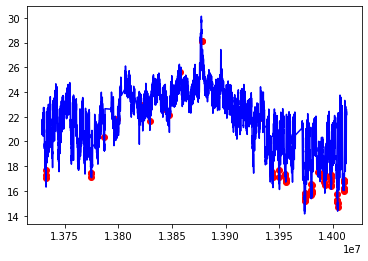

In [38]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

In [39]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

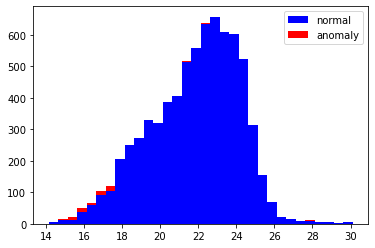

In [40]:
fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

# Cluster method detects the low temperature around the end of record as unusually low. It doesn't detect the highest temperature pic.

# ----------------------------------------------------------------------------------------

# Isolation Forest
Use for collective anomalies (unordered).
Simple, works well with different data repartition and efficient with high dimention data.

In [53]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)

IsolationForest(contamination=0.01)

In [54]:
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))

In [56]:
df['anomaly25'].value_counts()

 1    7196
-1      71
Name: anomaly25, dtype: int64

In [57]:
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    7196
1      71
Name: anomaly25, dtype: int64


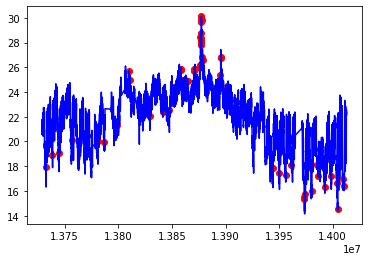

In [58]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

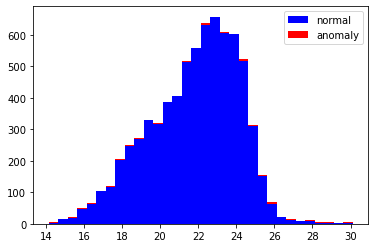

In [59]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

# ----------------------------------------------------------------------------------------

# One class SVM
Use for collective anomalies (unordered).
Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [61]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
print(df['anomaly26'].value_counts())

 1    7198
-1      69
Name: anomaly26, dtype: int64


In [62]:
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    7198
1      69
Name: anomaly26, dtype: int64


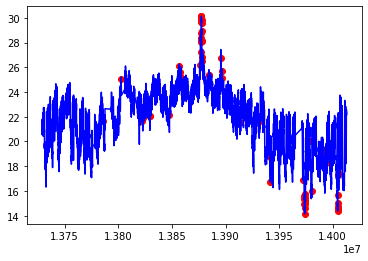

In [63]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

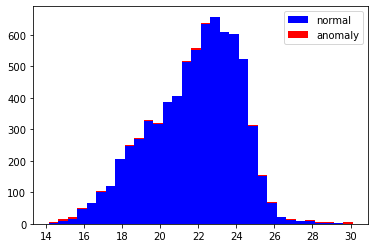

In [64]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()


- similar to isolation forest but find some anomalies in average values. Difficult to know if it's relevant.